# Import Libraries

In [3]:
import os
import torch
from torch import nn
from torchvision import ops
from torchvision.models import vgg16
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToPILImage
from torchvision.transforms import PILToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

/home/javad/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Use GPU If Available

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Preferred Device:", device)
torch.set_default_device(device)

Preferred Device: cuda


# Loading and Pre-Processing Data

In [5]:
curr_dir = os.getcwd()

In [6]:
train_dir = curr_dir + '/data/train/'
test_dir = curr_dir + '/data/test/'
valid_dir = curr_dir + '/data/valid/'

In [7]:
class CustomDataset(Dataset):

    def __init__(self, data_dir, scale_size=512, resize=True):
        self.root_dir = data_dir
        self.image_files = sorted([file for file in os.listdir(data_dir) if file.endswith('jpg')])
        self.xml_files = sorted([file for file in os.listdir(data_dir) if file.endswith('xml')])
        self.scale_size = scale_size
        self.transform = transforms.Compose([
            transforms.Resize((scale_size, scale_size)),
            transforms.ToTensor()])
        self.label_id = 0
        self.encoded_labels = {}
        self.decoded_labels = {}
        self.labels_count = {}
        self.resize = resize
        # fill encoded_labels, decoded_labels and labels_count dictionaries:
        self.labels_handler()


    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_files[index])
        xml_path = os.path.join(self.root_dir, self.xml_files[index])
        
        image = Image.open(image_path).convert('RGB')

        tensor_image = PILToTensor()(image)
    
        if self.resize:
            # resize and normalize image:
            resized_image = self.transform(image)
        
        data = self.parse_xml(xml_path)

        label = data['label']
        
        image_width, image_height = data['size']['width'], data['size']['height']
        
        bndbox_coordinates = [
            data['bounding_box']['xmin'],
            data['bounding_box']['ymin'],
            data['bounding_box']['xmax'],
            data['bounding_box']['ymax']
        ]

        if self.resize:
            # resize bounding box coordinates
            resized_bndbox_coordinates = [
                self.transform_coord(data['bounding_box']['xmin'], image_width),
                self.transform_coord(data['bounding_box']['ymin'], image_height),
                self.transform_coord(data['bounding_box']['xmax'], image_width),
                self.transform_coord(data['bounding_box']['ymax'], image_height)
            ]

        if self.resize:
            return (resized_image, torch.tensor(self.encoded_labels[label]),
                    torch.tensor(resized_bndbox_coordinates))
        else:
            return tensor_image, self.encoded_labels[label], torch.tensor(bndbox_coordinates)
    

    def parse_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
    
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        depth = int(root.find('size/depth').text)

        object_elem = root.find('object')

        label = object_elem.find('name').text
    
        xmin = int(object_elem.find('bndbox/xmin').text)
        xmax = int(object_elem.find('bndbox/xmax').text)
        ymin = int(object_elem.find('bndbox/ymin').text)
        ymax = int(object_elem.find('bndbox/ymax').text)

        data = {
            'label': label,
            'bounding_box': {
                'xmin': xmin,
                'xmax': xmax,
                'ymin': ymin,
                'ymax': ymax
            },
            'size': {
                'width': width,
                'height': height,
                'depth': depth
            }
        }

        return data

    
    def labels_handler(self):
        for i in range(len(self.xml_files)):
            xml_path = os.path.join(self.root_dir, self.xml_files[i])
            data = self.parse_xml(xml_path)
            label = data['label']

            if label in self.encoded_labels:
                self.labels_count[label] += 1
            else:
                self.label_id += 1
                self.encoded_labels[label] = self.label_id
                self.decoded_labels[self.label_id] = label
                self.labels_count[label] = 1
            
    
    def transform_coord(self, coord, im_dim):
        return int((coord / im_dim) * self.scale_size)

In [8]:
sample_dataset = CustomDataset(data_dir=train_dir, resize=False)

In [9]:
sample_dataset.labels_count

{'smoke': 516}

In [10]:
sample_dataset.encoded_labels

{'smoke': 1}

## Sample Images Visualizing

In [11]:
def plot_samples(n_samples, dataset, is_normalized):

    _, axes = plt.subplots(nrows=n_samples, ncols=1, figsize=(20, 20))

    for i in range(n_samples):
        image, _, bbox = dataset[i]
        
        if is_normalized:
            image = (image * 255).to(torch.uint8)

        bbox = bbox.unsqueeze(0)
        image = draw_bounding_boxes(image, bbox, width=4, colors='blue')
        image = ToPILImage()(image)
        axes[i].imshow(image)
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    plt.tight_layout()

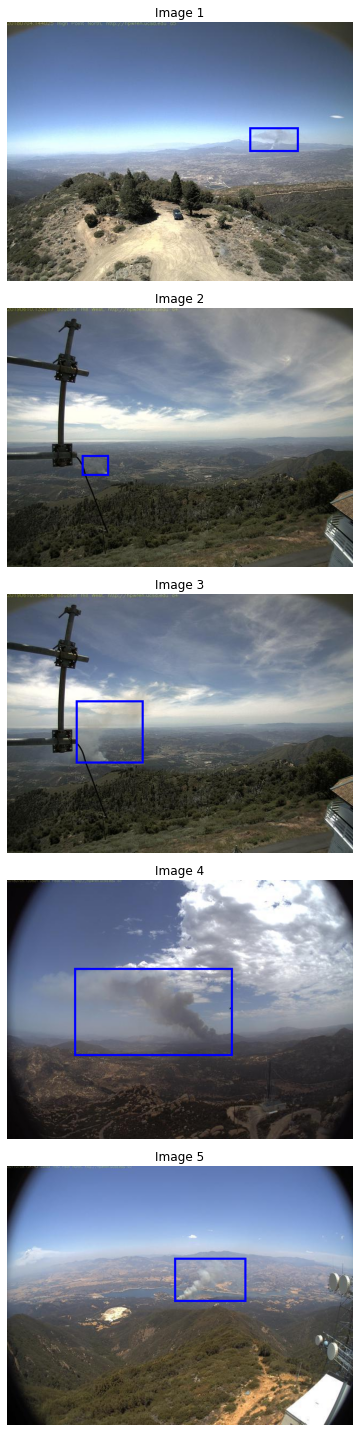

In [12]:
plot_samples(5, sample_dataset, is_normalized=False)

In [13]:
resized_sample_dataset = CustomDataset(train_dir, resize=True)

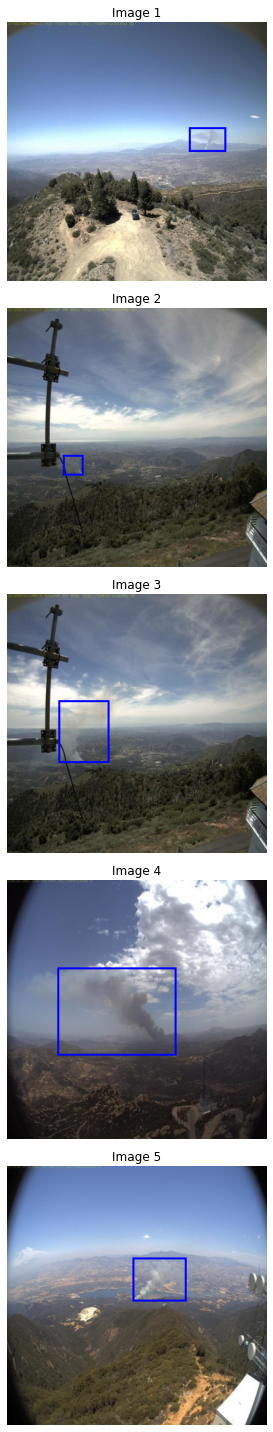

In [14]:
plot_samples(5, resized_sample_dataset, is_normalized=True)

In [15]:
batch_size = 4

In [16]:
train_data = CustomDataset(train_dir, resize=True)
validation_data = CustomDataset(valid_dir, resize=True)
test_data = CustomDataset(test_dir, resize=True)

In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

In [18]:
for ss in train_data[0]:
    print(np.shape(ss))

torch.Size([3, 512, 512])
torch.Size([])
torch.Size([4])


In [19]:
s = next(iter(train_loader))

for ss in s:
    print(np.shape(ss))

torch.Size([4, 3, 512, 512])
torch.Size([4])
torch.Size([4, 4])


In [20]:
def print_data_count():
    train_count = train_data.labels_count['smoke']
    validation_count = validation_data.labels_count['smoke']
    test_count = test_data.labels_count['smoke']
    
    print(f'Found {train_count} images in train data')
    print(f'Found {validation_count} images in validation data')
    print(f'Found {test_count} images in test data')

In [21]:
print_data_count()

Found 516 images in train data
Found 147 images in validation data
Found 74 images in test data


# Visualizing to Understand Better

## Backbone

As the paper mentioned, the pre-trained VGG16 model is used in the Faster R-CNN model. Therefore, the dimensions of the convolutional layers come from it! 

In [22]:
class PartialVGG16(nn.Module):
    def __init__(self, n_image_channels):
        super(PartialVGG16, self).__init__()

        self.network = nn.Sequential(
            # Block 1:
            nn.Conv2d(in_channels=n_image_channels, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),

            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),

            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # Block 2:
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # Block 3:
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # Block 4:
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),

            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            # Block 5:
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=(3, 3), padding=1, stride=(1,1)),
            
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        )

    def forward(self, x):
        return self.network(x)

In [23]:
vgg16_model = vgg16(pretrained=True)

/home/javad/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javad/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
vgg16_partial = torch.nn.Sequential(*list(vgg16_model.features.children()))

In [25]:
vgg16_partial.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [26]:
with torch.no_grad():
    feature_map = vgg16_partial(train_data[10][0].to('cuda'))

### Backbone Visualization

In [27]:
img, _, _ = train_data[10]
partialVGG16 = PartialVGG16(img.shape[0])
img_fm = partialVGG16(img.to("cuda"))
img = img.permute(1, 2, 0).numpy()

In [28]:
summary(partialVGG16, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [29]:
def img_to_cpu(img):
    img = img.cpu()
    img = img.detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    
    return img

In [30]:
def plot_feature_map(img_fm):
    img_fm = img_to_cpu(img_fm)

    # Since the output feature map of partial VGG16 has 512 channels,
    # we select nrows and ncols so that their product is 512.
    _, axes = plt.subplots(nrows=16, ncols=32, figsize=(16, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(img_fm[:, :, i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Now, let's examine the impact of the backbone on a sample training image

(-0.5, 511.5, 511.5, -0.5)

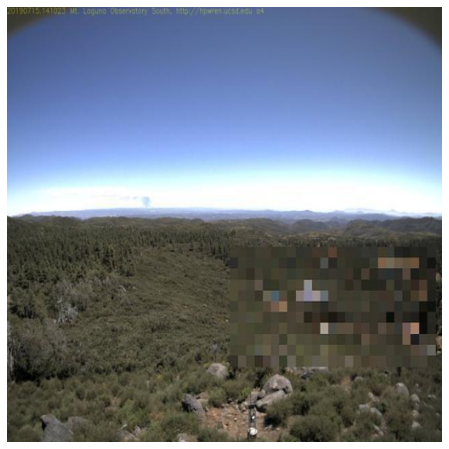

In [31]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
axes.imshow(img)
axes.axis('off')

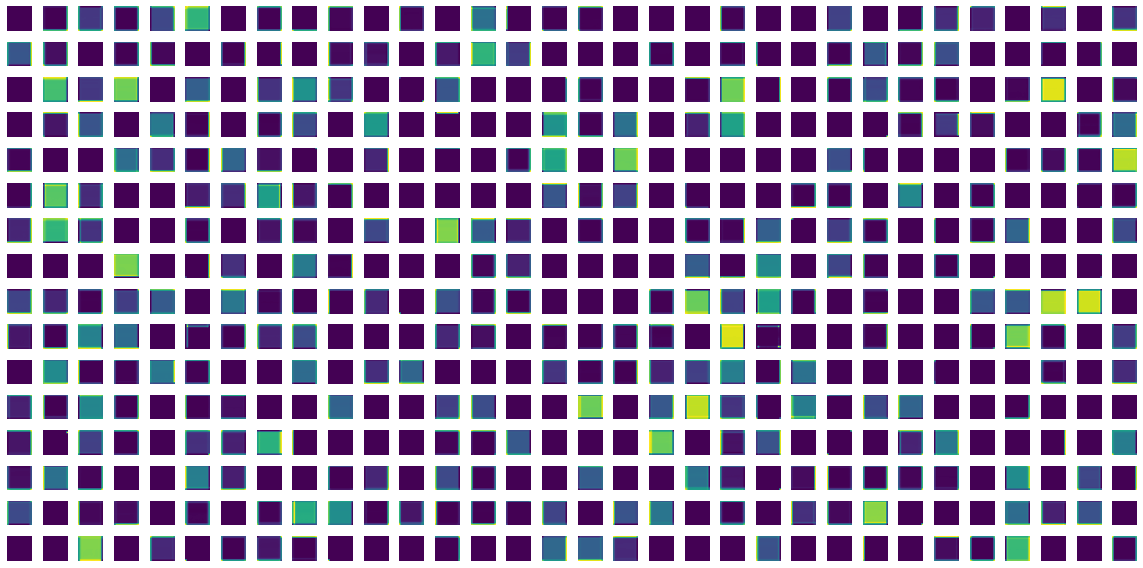

In [32]:
plot_feature_map(img_fm)

In [33]:
print(img_fm.shape)

torch.Size([512, 16, 16])


In [34]:
img_fm.shape == feature_map.shape

True

In [35]:
print(img.shape)

(512, 512, 3)


In [36]:
img_fmm = img_to_cpu(img_fm)

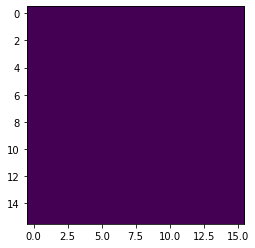

In [37]:
plt.imshow(img_fmm[:, :, 0])

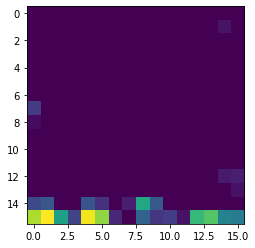

In [38]:
plt.imshow(feature_map[0].cpu())

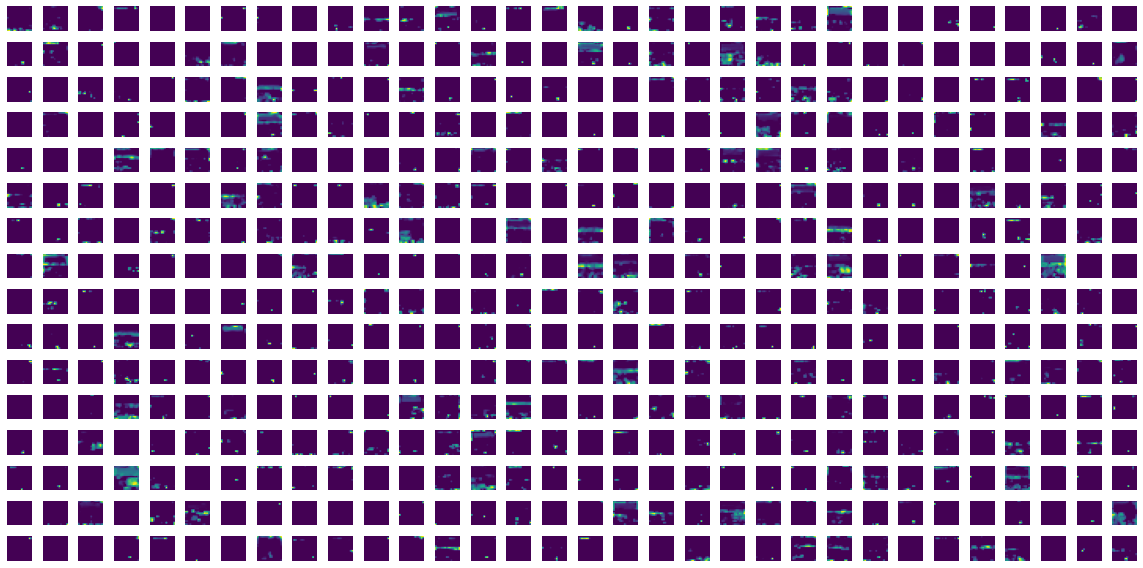

In [39]:
plot_feature_map(feature_map)

As you can see, after an image passes through the backbone, it is downscaled by (32, 32). Additionally, when utilizing a custom VGG16 network with no training (because we had no training data for this project to train VGG16!) and random weights, it results in a defective feature map, and the model is unable to learn image features. Therefore, we have decided to utilize a pre-trained VGG16 model for the backbone!

In [40]:
width_scale_factor = img.shape[0] // img_fm.shape[1]
height_scale_factor = img.shape[1] // img_fm.shape[2]

In [41]:
sample_img_data = [train_data[0][0].cpu(), train_data[1][0].cpu()]

In [42]:
sample_gt_data = [train_data[0][2].cpu(), train_data[1][2].cpu()]

In [43]:
sample_label_data = [train_data[0][1].cpu(), train_data[1][1].cpu()]

# Utils

## Generating Anchor Points

We consider each point in the feature map as an anchor point. So anchor points would just be
an array representing coordinates along the width and height dimensions

In [44]:
def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)

    return fig, axes

In [45]:
def gen_anc_centers(out_size):
    out_h, out_w = out_size
    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5
    
    return anc_pts_x.cpu(), anc_pts_y.cpu()

In [46]:
fm_h, fm_w = img_fm.shape[1], img_fm.shape[2]

In [47]:
anc_pts_x, anc_pts_y = gen_anc_centers((fm_w, fm_h))

### Displaying Anchor Points on Image

In [48]:
def display_image(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img_to_cpu(img)
        axes[i].imshow(img)
        axes[i].axis('off')
    
    return fig, axes

In [49]:
def display_grid(x_points, y_points, fig, ax, special_point=None):
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')
        
    return fig, ax

In [50]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

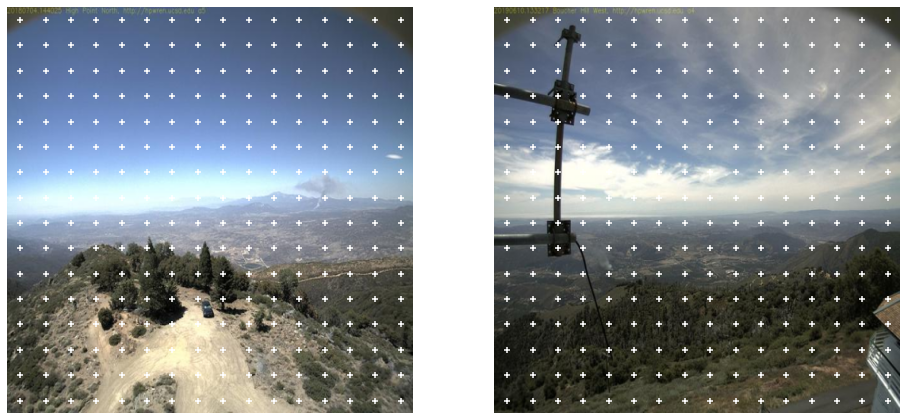

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

fig, axes = display_image(sample_img_data, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

## Generating Anchor Boxes

For each anchor point, we'll generate 9 bounding boxes of different shapes and sizes, as mentioned in the paper.

In [52]:
def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_aspect_ratios, fm_size):
    n_anc_boxes = 9
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) 
    # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]
    # Hmap: feature map height
    # Wmap: feature map width

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for _, scale in enumerate(anc_scales):
                for _, aspect_ratio in enumerate(anc_aspect_ratios):
                    w = scale * aspect_ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=fm_size)
 
    return anc_base

In [53]:
anc_scales = [2, 4, 6]
anc_aspect_ratios = [0.5, 1, 1.5]

n_anc_boxes = len(anc_scales) * len(anc_aspect_ratios)

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_aspect_ratios, (fm_h, fm_w))

In [54]:
sample_anc_boxes = anc_base.repeat(len(sample_img_data), 1, 1, 1, 1)
# sample_anc_boxes = all anc boxes for a batch of images

In [55]:
sample_anc_boxes = sample_anc_boxes.cpu()

### Displaying Anchor Boxes on A Single Anchor Point

In [56]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes
    
    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        # proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        # proj_bboxes[:, :, [1, 3]] /= height_scale_factor
        
        proj_bboxes[:, :, [0, 2]] = proj_bboxes[:, :, [0, 2]] // width_scale_factor
        proj_bboxes[:, :, [1, 3]] = proj_bboxes[:, :, [1, 3]] // height_scale_factor
        
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)
    
    return proj_bboxes

In [57]:
def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='blue', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    
    c = 0

    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width,
                                 edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='blue', alpha=0.5))
        c += 1
        
    return fig, ax

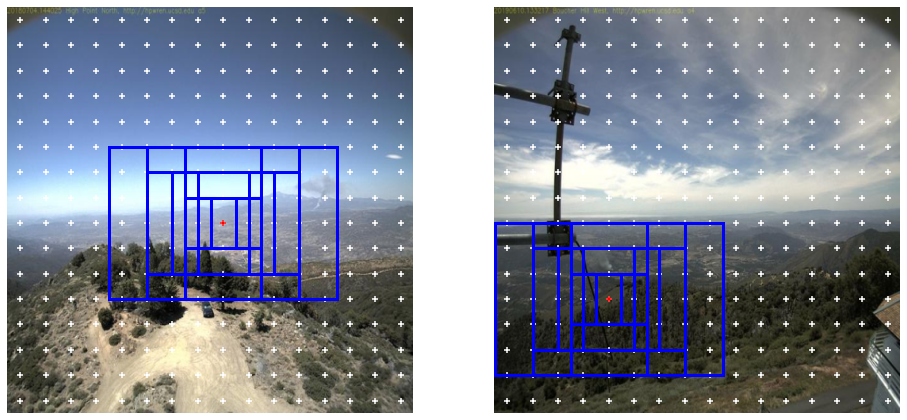

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

fig, axes = display_image(sample_img_data, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(sample_anc_boxes, width_scale_factor,
                                height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
point_1 = [8, 8]
ponit_2 = [4, 11]

bboxes_1 = anc_boxes_proj[0][point_1[0], point_1[1]]
bboxes_2 = anc_boxes_proj[1][ponit_2[0], ponit_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0],
                      (anc_pts_x_proj[point_1[0]], anc_pts_y_proj[point_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1],
                      (anc_pts_x_proj[ponit_2[0]], anc_pts_y_proj[ponit_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

### Displaying Anchor Boxes on All Anchor Points

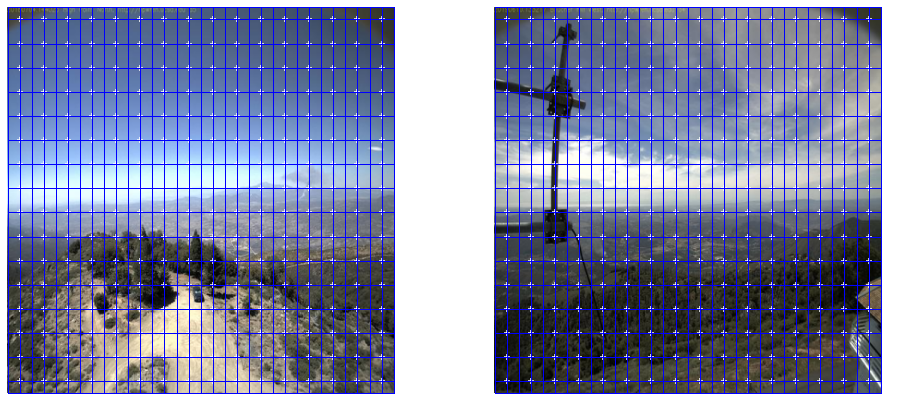

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

fig, axes = display_image(sample_img_data, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [60]:
positive_thresh = 0.7
negative_thresh = 0.3

In [61]:
gt_bboxes_proj = project_bboxes(torch.stack(sample_gt_data), width_scale_factor,
                                height_scale_factor, mode='p2a')

In [62]:
def get_iou_mat(batch_size, all_anc_boxes, all_gt_bboxes):
    
    # flatten anchor boxes
    flat_anc_boxes = all_anc_boxes.reshape(batch_size, -1, 4)
    # get total anchor boxes for a single image
    tot_anc_boxes = flat_anc_boxes.size(dim=1)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, all_gt_bboxes.size(dim=1)))
    ious_mat = ious_mat.cpu()

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = all_gt_bboxes[i]
        anc_boxes = flat_anc_boxes[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes).cpu()

    return ious_mat

In [63]:
def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1).cpu()

In [64]:
def get_req_anchors(all_anc_boxes, all_gt_bboxes, all_gt_classes,
                    positive_thresh=0.7, negative_thresh=0.3):
    
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = all_anc_boxes.shape
    N = all_gt_bboxes.shape[1]   # max number of groundtruth bboxes in a batch.

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, all_anc_boxes, all_gt_bboxes)

    # for every groundtruth bbox in an image, find the iou 
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0).cpu() 
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > positive_thresh).cpu()
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0].cpu() 
    # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0].cpu()
    
    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)
    
    max_iou_per_anc = max_iou_per_anc.cpu()
    max_iou_per_anc_ind = max_iou_per_anc_ind.cpu()
    positive_anc_ind = positive_anc_ind.cpu()
    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    
    # expand gt classes to map against every anchor box
    gt_classes_expand = all_gt_classes.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    gt_classes_expand = gt_classes_expand.cpu()

    GT_class = torch.gather(gt_classes_expand, -1,
                            max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]
    
    # get gt bbox coordinates of the +ve anchor boxes
    
    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = all_gt_bboxes.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it 
    # overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2,
                             max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    
    # get coordinates of +ve anc boxes
    anc_boxes_flat = all_anc_boxes.flatten(start_dim=0, end_dim=-2) 
    # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)
    
    # get -ve anchors
    
    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < negative_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0].cpu()
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0],
                                                      (positive_anc_ind.shape[0],)).cpu()]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

In [65]:
torch.stack(sample_label_data).shape

torch.Size([2])

In [66]:
gt_bboxes_proj.shape

torch.Size([2, 4])

In [67]:
gt_bboxes_proj_s = gt_bboxes_proj.unsqueeze(1)

In [68]:
sample_label_data_s = torch.stack(sample_label_data).unsqueeze(1)

In [69]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(sample_anc_boxes,
                                                            gt_bboxes_proj_s,
                                                            sample_label_data_s,
                                                            positive_thresh, negative_thresh)

#### Visualize Positive Anchor Boxes

In [70]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor,
                              height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor,
                              height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

In [71]:
sample_gt_data_s = torch.stack(sample_gt_data).cpu()

In [72]:
for x in sample_gt_data_s[0].unsqueeze(0):
    print(x)

tensor([358, 209, 431, 257])


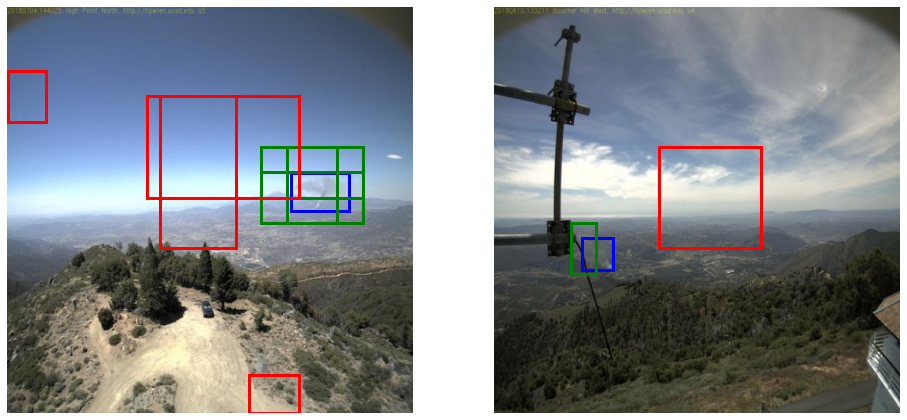

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

fig, axes = display_image(sample_img_data, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(sample_gt_data_s[0].unsqueeze(0), fig, axes[0])
fig, _ = display_bbox(sample_gt_data_s[1].unsqueeze(0), fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

In [74]:
vgg16_partial

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Designing Model

## Feature Extractor Module

In [75]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = vgg16(pretrained=True)
        self.backbone = torch.nn.Sequential(*list(model.features.children()))

        for param in self.backbone.named_parameters():
            param[1].requires_grad = True

    def forward(self, img_data):
        return self.backbone(img_data)

## Proposal Module

In [76]:
def generate_proposals(anchors, offsets):
    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

In [77]:
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)
        
    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'

        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        
        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)
        
        if mode == 'train': 
            # get conf scores 
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)
            
            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals
            
        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred

## Loss Utils

In [78]:
def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)
    
    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))

    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size

    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

## RPN Module

In [79]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size

        # downsampling scale factor 
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)

        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

        # weights for loss
        self.w_conf = 1
        self.w_reg = 5

        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)

        feature_map = self.feature_extractor(images)
        # feature_map = self.feature_extractor(images.to('cuda'))

        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))

        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales,
                                self.anc_ratios, (self.out_h, self.out_w))
        
        all_anc_boxes = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get positive and negative anchors amongst other things
        # gt_bboxes should be in torch.stack format
        gt_bboxes_s = torch.stack(gt_bboxes)

        gt_bboxes_proj = project_bboxes(gt_bboxes_s, self.width_scale_factor,
                                        self.height_scale_factor, mode='p2a')
        
        # Adding max object dimension:
        gt_bboxes_proj_s = gt_bboxes_proj.unsqueeze(1)
        gt_classes_s = torch.stack(gt_classes).unsqueeze(1)

        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(all_anc_boxes,
                                                                    gt_bboxes_proj_s,
                                                                    gt_classes_s)
        # gt_bboxes_proj.unsqueeze(1)
        # torch.stack(gt_classes).unsqueeze(1)
        
        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, \
        offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind,
                                                        negative_anc_ind,
                                                        positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss

        return (total_rpn_loss, feature_map, proposals,
                positive_anc_ind_sep, GT_class_pos)
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            feature_map = self.feature_extractor(images)

            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios,
                                    (self.out_h, self.out_w))
            all_anc_boxes = anc_base.repeat(batch_size, 1, 1, 1, 1)
            flattened_anc_boxes = all_anc_boxes.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            final_proposals = []
            final_conf_scores = []

            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = flattened_anc_boxes[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                final_proposals.append(proposals_pos)
                final_conf_scores.append(conf_scores_pos)

        return final_proposals, final_conf_scores, feature_map

## Classification Module

In [80]:
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)
        
        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes)

    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'

        # apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        
        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross entropy loss
        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())
        
        return cls_loss

## Two Stage Detector Module

In [81]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
    def forward(self, images, gt_bboxes, gt_classes):
        print(f"[0]::{np.shape(images)}::{np.shape(gt_bboxes)}::{np.shape(gt_classes)}")
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
        print(f"[1]::RPN success")
        
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        print(f"[2]::{batch_size}")

        for idx in range(batch_size):
            print(f"[3]::{idx}")
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)

        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss
    
    @torch.no_grad()
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images,
                                                                             conf_thresh,
                                                                             nms_thresh)

        cls_scores = self.classifier(feature_map, proposals_final)
        
        # convert scores into probability
        cls_probs = F.softmax(cls_scores, dim=-1)
        # get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)
        
        classes_final = []
        # slice classes to map to their corresponding image
        c = 0

        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals

        return proposals_final, conf_scores_final, classes_final

# Training The Faster C-RNN

In [82]:
feature_map.shape

torch.Size([512, 16, 16])

In [83]:
img_size = (512, 512)
fm_size = (feature_map[1], feature_map.shape[2])
fm_c = feature_map.shape[0]
n_classes = len(sample_dataset.labels_count)
roi_size = (2, 2)

learning_rate = 1e-3
n_epochs = 10

In [84]:
detector = TwoStageDetector(img_size, fm_size, fm_c, n_classes, roi_size)


In [85]:
detector = detector.to('cuda')

In [86]:
def training_loop(model, learning_rate, train_dataloader, val_dataloader, n_epochs):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print("Preferred Device:", device)
    torch.set_default_device(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    model.train()
    train_loss_list = []
    val_loss_list = []
    
    for epoch in tqdm(range(n_epochs)):
        total_train_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)

            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        train_loss_list.append(total_train_loss)

        model.eval()
        with torch.no_grad():
            total_val_loss = 0

            for val_img_batch, val_gt_bboxes_batch, val_gt_classes_batch in val_dataloader:
                
                val_img_batch = val_img_batch.to(device)
                val_gt_bboxes_batch = val_gt_bboxes_batch.to(device)
                val_gt_classes_batch = val_gt_classes_batch.to(device)

                val_loss = model(val_img_batch, val_gt_bboxes_batch, val_gt_classes_batch)

                total_val_loss += val_loss.item()

            val_loss_list.append(total_val_loss)

        model.train()

    return train_loss_list, val_loss_list


In [87]:
train_loss_list, val_loss_list = training_loop(detector, learning_rate, train_loader,
                                               validation_loader, n_epochs) 

Preferred Device: cuda


100%|██████████| 10/10 [00:00<00:00, 163202.49it/s]


In [89]:
def plot_losses(train_loss_list, val_loss_list):
    epochs = range(n_epochs)
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

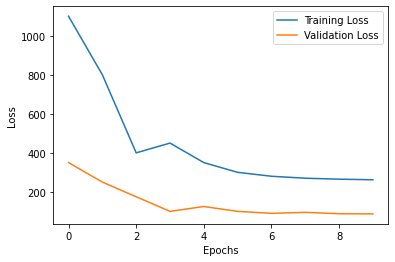

In [90]:
plot_losses(train_loss_list, val_loss_list)

In [91]:
for img_batch, gt_bboxes_batch, gt_classes_batch in test_loader:
    all_img_data = img_batch
    all_gt_bboxes = gt_bboxes_batch
    all_gt_classes = gt_classes_batch
    break

all_img_data = all_img_data[:5]
all_gt_bboxes = all_gt_bboxes[:5]
all_gt_classes = all_gt_classes[:5]

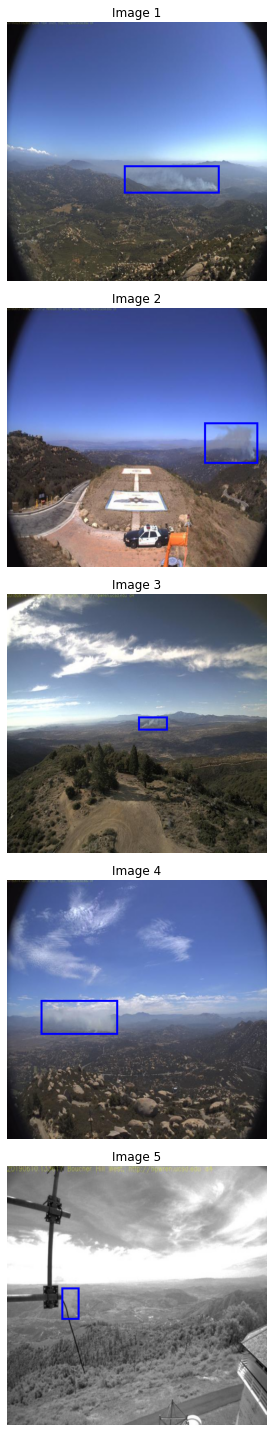

In [92]:
plot_samples(5, test_data, is_normalized=True)

In [ ]:
detector.eval()
detector = detector.to('cuda')
proposals_final, conf_scores_final, classes_final = detector.inference(all_img_data.to('cuda'),
                                                                       conf_thresh=0.8,
                                                                       nms_thresh=0.05)

In [ ]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

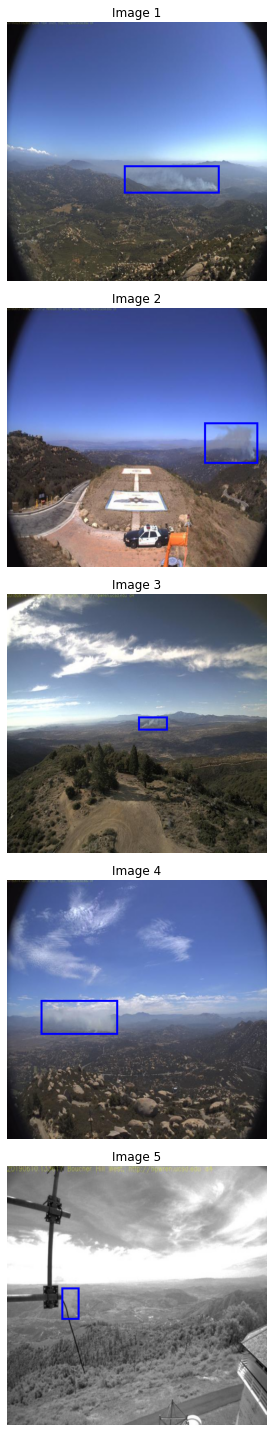

In [113]:
nrows, ncols = (1, 5)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_image(img_batch, fig, axes)

fig, _ = display_bbox(prop_proj_1.to('cpu'), fig, axes[0])
fig, _ = display_bbox(prop_proj_2.to('cpu'), fig, axes[1])
fig, _ = display_bbox(prop_proj_2.to('cpu'), fig, axes[2])
fig, _ = display_bbox(prop_proj_2.to('cpu'), fig, axes[3])
fig, _ = display_bbox(prop_proj_2.to('cpu'), fig, axes[4])
